In [1]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

import flaml
from flaml import AutoML

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

if os.path.exists('/media/ssd_2tb_evo/DL_based_wind_profile_estimation'):
    root_dir = '/media/ssd_2tb_evo/DL_based_wind_profile_estimation'
elif os.path.exists('/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'):
    root_dir = '/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'
else:
    root_dir = '/Users/harishbaki/Ongoing_Research/DL_based_wind_profile_estimation'

sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_ERA5_to_CERRA.yaml' #sys.argv[1]
train_years = int(17) #int(sys.argv[2])
Ens = 0 #int(sys.argv[3]) #ensemble number

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    configure = yaml.safe_load(yaml_file)
input_file = configure['input_file']
input_times_freq = configure['input_times_freq']
Coeff_file = configure['Coeff_file']
profiles_file = None if configure['profiles_file'] == '' else configure['profiles_file']
input_variables = configure['input_variables']
train_locations = configure['train_locations']
test_dates_range = configure['test_dates_range']
test_locations = configure['test_locations']
nEns = configure['nEns']
tabnet_param_file = configure['tabnet_param_file']
target_variables = configure['target_variables']
experiment = configure['experiment']

In [2]:
xr.open_dataset(input_file)

<xarray.Dataset> Size: 1GB
Dimensions:       (location: 11, time: 166560)
Coordinates:
    longitude     (location) float32 44B ...
    latitude      (location) float32 44B ...
  * time          (time) datetime64[ns] 1MB 2000-01-01 ... 2018-12-31T23:00:00
    year          (time) int64 1MB ...
Dimensions without coordinates: location
Data variables: (12/98)
    u10           (location, time) float64 15MB ...
    v10           (location, time) float64 15MB ...
    u100          (location, time) float64 15MB ...
    v100          (location, time) float64 15MB ...
    zust          (location, time) float64 15MB ...
    i10fg         (location, time) float64 15MB ...
    ...            ...
    u_950_skew    (location, time) float64 15MB ...
    u_950_kurt    (location, time) float64 15MB ...
    v_950_mean    (location, time) float64 15MB ...
    v_950_std     (location, time) float64 15MB ...
    v_950_skew    (location, time) float64 15MB ...
    v_950_kurt    (location, time) float64 15MB ...

In [7]:
input_variables = [
    "10ws", "100ws", "100alpha", "975ws", "950ws", "975wsgrad", "950wsgrad",
    "zust", "i10fg", "t2m", "skt", "stl1", "d2m", "msl", "blh", "ishf", 
    "ie", "tcc", "lcc", "cape", "bld", "t_975", "t_950", "2mtempgrad", 
    "sktempgrad", "dewtempsprd", "975tempgrad", "950tempgrad", "sinHR", 
    "cosHR", "sinJDAY", "cosJDAY",
    "u10","v10","u100","v100","u_950","v_950","u_975","v_975",
    "u10_mean","u10_std","u10_skew","u10_kurt",
    "v10_mean","v10_std","v10_skew","v10_kurt",
    "u100_mean","u100_std","u100_skew","u100_kurt",
    "v100_mean","v100_std","v100_skew","v100_kurt",
    "u_950_mean","u_950_std","u_950_skew","u_950_kurt",
    "v_950_mean","v_950_std","v_950_skew","v_950_kurt",
    "u_975_mean","u_975_std","u_975_skew","u_975_kurt",
    "v_975_mean","v_975_std","v_975_skew","v_975_kurt",
]

In [4]:
test_dates_range

['2017-03-24T00:00:00', '2018-04-11T23:00:00']

In [5]:
# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2017-10-17T03:00:00','2017-06-06T10:00:00'],
                'Low shear/well mixed':['2017-05-10T12:00:00','2017-11-20T13:00:00'],
                'LLJ': ['2018-04-10T03:00:00','2017-03-30T02:00:00'],
                'High wind': ['2017-12-31T12:00:00','2018-01-05T04:00:00'],
                }
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

In [8]:
#for run,year in enumerate(np.arange(2000,2017+1-train_years)):
train_dates_range = ['2000-01-01T12','2016-12-31']
print(train_dates_range)

# === training and validation data parameters ===#
X_train,Y_train, X_valid,Y_valid = data_processing(input_file,Coeff_file,input_times_freq,
                                                    input_variables,target_variables,train_dates_range,train_locations,val_arg=True,
                                                    profiles_file=profiles_file,threshold=2)
print('training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape,'validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)

['2000-01-01T12', '2016-12-31']
training inputs shape: (109925, 72) training targets shape: (109925, 5) validation inputs shape: (27219, 72) validation targets shape: (27219, 5)


In [9]:
import pandas as pd

# Define the start and end dates
start_date = pd.Timestamp('2000-01-01T12')
end_date = pd.Timestamp('2016-12-31')

# Calculate the number of hours between the dates
hours_between = (end_date - start_date).total_seconds() / 3600

print("Number of hours between 2000 Jan 1 and 2016 Dec 31:", hours_between)


Number of hours between 2000 Jan 1 and 2016 Dec 31: 149004.0


### Simple AutoML xgboost regresison or lgbm
- Experimented with xgboost, but the performance is quite unsatisfactory

In [18]:
automl_settings = {
    "time_budget": 3600,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['xgboost'],
    "early_stop": True,
    "model_history": True, #A boolean of whether to keep the best model per estimator
    "retrain_full": True, #whether to retrain the selected model on the full training data
    "custom_hp": {
        "xgboost": {
            "tree_method": {
                "domain": "gpu_hist",       # Use GPU for tree construction
                "type": "fixed"
            },
            "predictor": {
                "domain": "gpu_predictor",  # Use GPU for prediction
                "type": "fixed"
            }
        }
    }
}

In [19]:
trained_models = {}
# === Target variables ===#
target_variables = [0,1,2,3,4] #represent coefficients from 0 to 4
for i,target_variable in enumerate(target_variables):
    # === initialize automl regressor ===#
    automl = AutoML()
    # === Train AUTOML regressor ===#
    X_tr,y_tr,X_val,y_val = np.hstack([X_train,Y_train[:,0:i]]), Y_train[:,i:i+1], np.hstack([X_valid,Y_valid[:,0:i]]), Y_valid[:,i:i+1]
    print(X_tr.shape,y_tr.shape,X_val.shape,y_val.shape)

    automl.fit(X_train=X_tr, y_train = y_tr,X_val=X_val, y_val=y_val, **automl_settings)

    # === save the model ===#
    trained_models[f'Coefficient_{target_variable}'] = automl

(109925, 72) (109925, 1) (27219, 72) (27219, 1)
[flaml.automl.logger: 03-11 00:32:10] {1728} INFO - task = regression
[flaml.automl.logger: 03-11 00:32:10] {1736} INFO - Data split method: uniform
[flaml.automl.logger: 03-11 00:32:10] {1739} INFO - Evaluation method: holdout


[flaml.automl.logger: 03-11 00:32:10] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 03-11 00:32:10] {1955} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 03-11 00:32:10] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 03-11 00:32:10] {2393} INFO - Estimated sufficient time budget=4070s. Estimated necessary time budget=4s.
[flaml.automl.logger: 03-11 00:32:10] {2442} INFO -  at 0.1s,	estimator xgboost's best error=3.3100,	best estimator xgboost's best error=3.3100
[flaml.automl.logger: 03-11 00:32:10] {2258} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 03-11 00:32:10] {2442} INFO -  at 0.1s,	estimator xgboost's best error=3.3100,	best estimator xgboost's best error=3.3100
[flaml.automl.logger: 03-11 00:32:10] {2258} INFO - iteration 2, current learner xgboost
[flaml.automl.logger: 03-11 00:32:10] {2442} INFO -  at 0.1s,	estimator xgboost's best error=1.9045,	best estimator xgboost's best error

In [13]:
# === testing data parameters ===#
X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (9216, 72) testing targets shape: (9216, 5)


(9216, 72) (9216, 1)
(9216, 1)
(9216, 73) (9216, 1)
(9216, 2)
(9216, 74) (9216, 1)
(9216, 3)
(9216, 75) (9216, 1)
(9216, 4)
(9216, 76) (9216, 1)
(9216, 5)


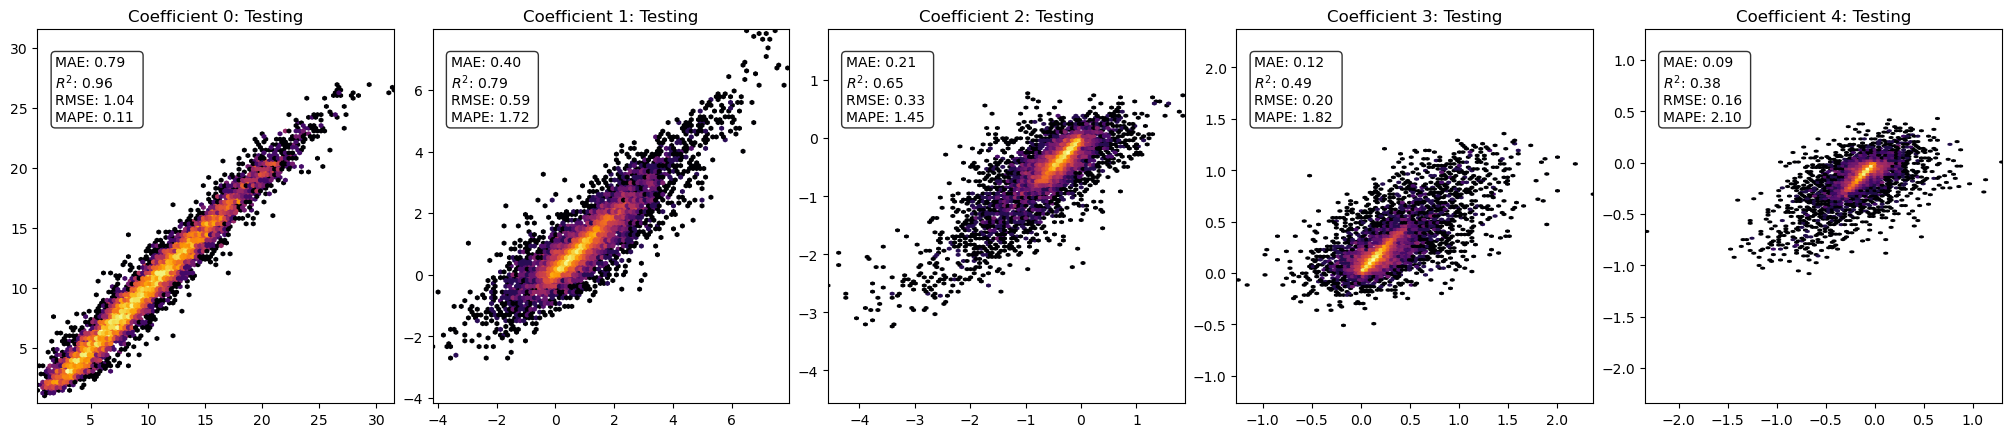

In [14]:
fig = plt.figure(figsize=(20, 8), constrained_layout=True)
gs = fig.add_gridspec(2,5)

Y_pred = []
for i,target_variable in enumerate(target_variables):
    X_te = X_test if i==0 else np.hstack([X_test,Y_pred])
    y_te = Y_test[:,i:i+1]
    print(X_te.shape,y_te.shape)
    y_pred = trained_models[f'Coefficient_{target_variable}'].predict(X_te)
    y_pred = y_pred.reshape(-1,1)
    Y_pred = np.hstack([Y_pred,y_pred]) if i>0 else y_pred
    print(Y_pred.shape)
    hexbin_plotter(fig,gs[0,i],y_te,y_pred,f'Coefficient {target_variable}: Testing',text_arg=True)

#plt.savefig(f'Figures/single_output_lgbm_CERRA_targets_coefficients_hexbin_plot.png',dpi=300)

In [15]:
CERRA_levels = [10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.]
ERA5_levels = [10, 100]
def profle_plotter(fig,gs,X_test,Y_test,ERA5_ws=None,Obs=None,date=None,title=None,xlabel=None,ylabel=None,train_years=None,run=None,experiment=experiment):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X_test[0,0:2] if ERA5_ws is None else ERA5_ws
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate observed profile
    M_true = WindProfile(Z, Y_test[0,:])
    axs.plot(M_true, Z, '-k', linewidth=2, markerfacecolor='r', label='CERRA')

    Mp = WindProfile(Z, Y_pred[0,:])

    # Plot Mp
    axs.plot(Mp, Z, linestyle='-', linewidth=2, label='XGBoost', markerfacecolor='b')

    axs.set_xlim([0, 30])
    axs.set_ylim([0, 500])

    if title is not None:
        axs.set_title(title)

    if xlabel is not None:
        axs.set_xlabel(xlabel)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    return axs

### Best profiles

High shear 2017-10-17T03:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[15.33193417  2.66993037 -0.4646765   0.2663663  -0.16420136]] [[17.491745    3.3453176  -0.5835169   0.19502151 -0.22539341]]
Low shear/well mixed 2017-05-10T12:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[ 8.10765582  0.26359341 -0.31311313  0.07156121 -0.08741899]] [[ 6.0460863   0.12923133 -0.21018398  0.06716311 -0.05674325]]
LLJ 2018-04-10T03:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[16.30681198 -0.92800532 -3.06863109  2.00501678  0.58292493]] [[16.675907    1.4350352  -2.9102688   1.1352819   0.03510433]]
High wind 2017-12-31T12:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[25.19863715  6.94316462 -0.8350925   0.22094535 -0.32442423]] [[23.395226    6.1780787  -1.0267143   0.22165073 -0.21634543]]


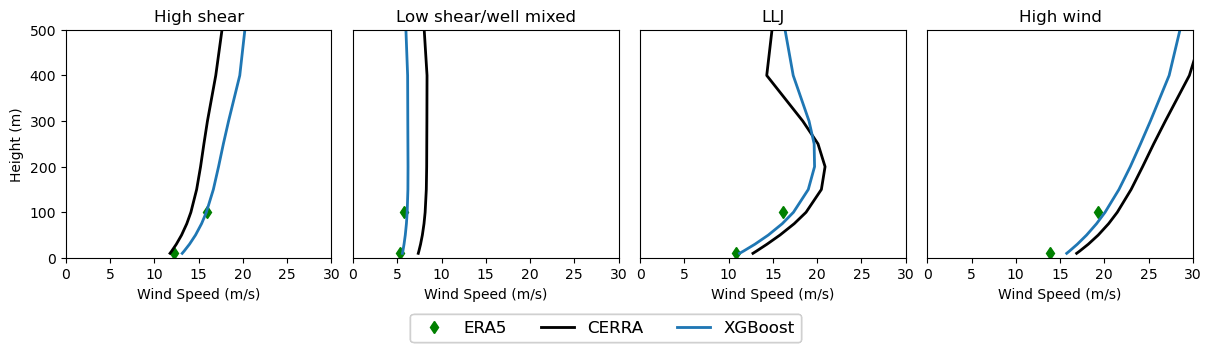

In [16]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)

for k,profile in enumerate(profile_dates):
    print(profile, profile_dates[profile][0])

    X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                    [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
    Y_pred = []
    for i,target_variable in enumerate(target_variables):
        X_te = X_test if i==0 else np.hstack([X_test,Y_pred])
        y_te = Y_test[:,i:i+1]
        print(X_te.shape,y_te.shape)
        y_pred = trained_models[f'Coefficient_{target_variable}'].predict(X_te)
        y_pred = y_pred.reshape(-1,1)
        Y_pred = np.hstack([Y_pred,y_pred]) if i>0 else y_pred
    print(Y_test,Y_pred)

    title = profile
    xlabel = f'Wind Speed (m/s)'
    ylabel = f'Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[0,k],X_test,Y_test,title=title,xlabel=xlabel,ylabel=ylabel)

    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)

### Worst profiles

High shear 2017-10-17T03:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[11.78586933  3.12908084 -1.07249947  0.5101237  -0.25783733]] [[13.05214     2.381416   -0.9649054   0.6301652  -0.22865948]]
Low shear/well mixed 2017-05-10T12:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[ 8.14243791 -0.49439757 -0.3273842   0.15240983 -0.06442316]] [[ 8.806389   -0.24724251 -0.4336902   0.06625678 -0.09270886]]
LLJ 2018-04-10T03:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[11.72834649  1.36331515 -1.93451881  0.62355557 -0.06616989]] [[10.354552   0.7682244 -1.5152938  0.8364575 -0.2911829]]
High wind 2017-12-31T12:00:00
(1, 72) (1, 1)
(1, 73) (1, 1)
(1, 74) (1, 1)
(1, 75) (1, 1)
(1, 76) (1, 1)
[[17.22867019  1.64469646 -0.96622431  0.07870711 -0.19200856]] [[12.852123    1.291548   -0.6342208   0.23665012 -0.12912497]]


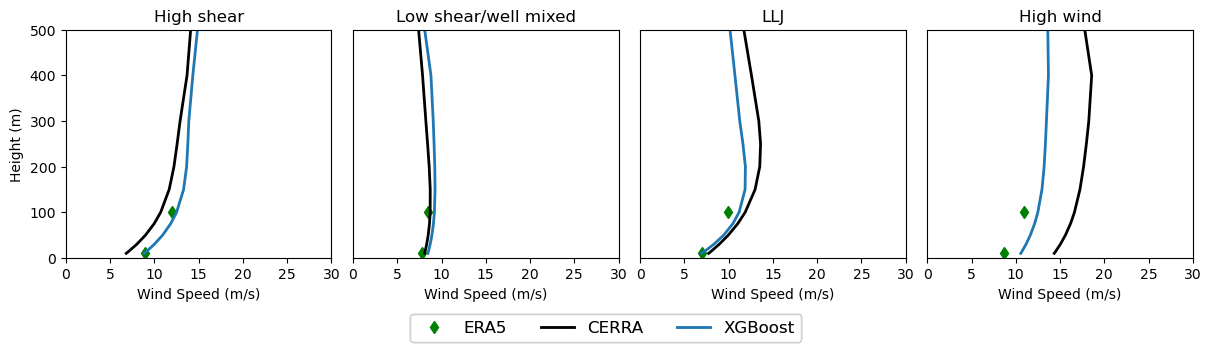

In [17]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)

for k,profile in enumerate(profile_dates):
    print(profile, profile_dates[profile][0])

    X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                    [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    Y_pred = []
    for i,target_variable in enumerate(target_variables):
        X_te = X_test if i==0 else np.hstack([X_test,Y_pred])
        y_te = Y_test[:,i:i+1]
        print(X_te.shape,y_te.shape)
        y_pred = trained_models[f'Coefficient_{target_variable}'].predict(X_te)
        y_pred = y_pred.reshape(-1,1)
        Y_pred = np.hstack([Y_pred,y_pred]) if i>0 else y_pred
    print(Y_test,Y_pred)

    title = profile
    xlabel = f'Wind Speed (m/s)'
    ylabel = f'Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[0,k],X_test,Y_test,title=title,xlabel=xlabel,ylabel=ylabel)

    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)